In [1]:
from collections import Counter, defaultdict
from itertools import chain

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk import pos_tag, ne_chunk, Tree
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans



## Data Preparation

In [2]:
bipolar_df = pd.read_csv('../data/RedditBipolar.csv', encoding='latin9', delimiter=';', parse_dates=['date'])
bipolar_df = bipolar_df[['date', 'author', 'post']]

In [3]:
print(bipolar_df.shape)
print(bipolar_df['post'].nunique())
print(bipolar_df['author'].nunique())
print(bipolar_df.info())

(1692, 3)
1692
1618
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1692 non-null   object
 1   author  1692 non-null   object
 2   post    1692 non-null   object
dtypes: object(3)
memory usage: 39.8+ KB
None


## Text Preprocessing

### Tokenization

In [4]:
bipolar_df['post_tokens_uppercase'] = bipolar_df['post'].apply(lambda x: nltk.word_tokenize(x))

### Stop word removal

In [5]:
stop_words = stopwords.words('english')
stop_words = stop_words + ['make', 'feel', 'like', 'going', 'thing', 'something', 'get', 'http', 'else', 'anyone', 'bipolar', 'disorder']

bipolar_df['post_tokens_lowercase'] = bipolar_df['post_tokens_uppercase'].apply(
  lambda x: [word.lower() for word in x if word.lower().isalpha() and word.lower() not in stop_words]
)

### POS tagging

In [6]:
bipolar_df['post_tokens_uppercase_with_pos_tags'] = bipolar_df['post_tokens_uppercase'].apply(pos_tag)

### Named entity recognition

In [ ]:
def extract_named_entities(tree):
  entities = []
  for node in tree:
    if isinstance(node, Tree): # instance of nameed entity
      entity_type = node.label()
      entity_words = " ".join(word for word, _ in node.leaves())
      entities.append((entity_words, entity_type))
  return entities

In [ ]:
bipolar_df['named_entities'] = bipolar_df['post_tokens_uppercase_with_pos_tags'].apply(
    lambda tagged: extract_named_entities(ne_chunk(tagged))
)


### Lemmatization

In [7]:
def map_pos_tags(tag: str):
  if tag.startswith('J'):
      return 'a'
  elif tag.startswith('V'):
      return 'v'
  elif tag.startswith('R'):
      return 'r'
  return 'n'

In [8]:
wnl = WordNetLemmatizer()

bipolar_df['post_lemmas_lowercase'] = bipolar_df['post_tokens_lowercase'].apply(lambda x: [wnl.lemmatize(word) for word in x])

bipolar_df['post_lemmas_uppercase'] = bipolar_df['post_tokens_uppercase_with_pos_tags'].apply(
  lambda tagged: [wnl.lemmatize(word=word, pos=map_pos_tags(tag)) for word, tag in tagged]
)

## Exploratory Analysis

### Word frequency analysis

In [9]:
all_lemmas = list(chain.from_iterable(bipolar_df['post_lemmas_lowercase']))
word_count = Counter(all_lemmas)

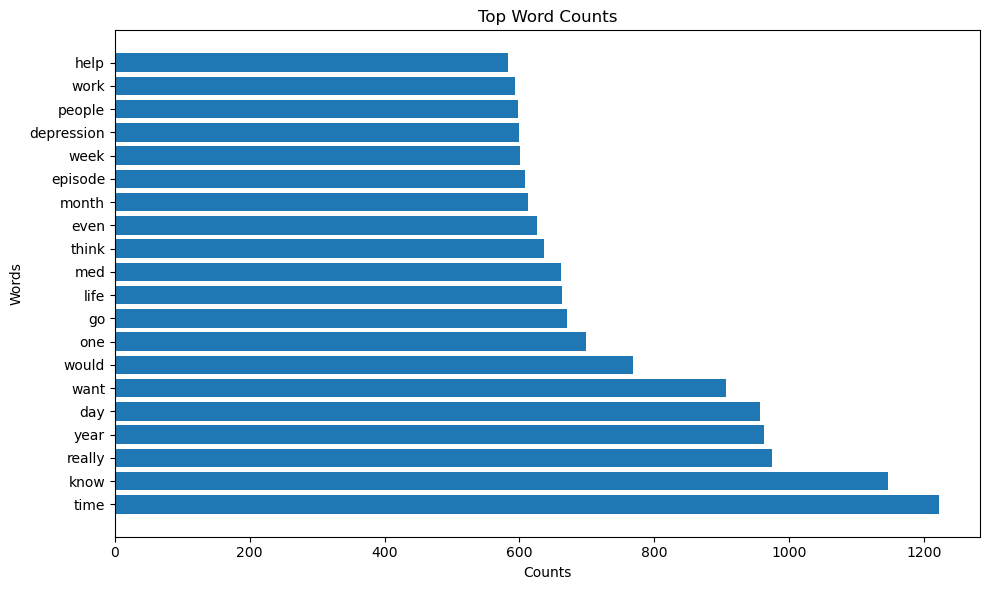

In [10]:
top_words = word_count.most_common(20)

words, counts = zip(*top_words)

plt.figure(figsize=(10, 6))
plt.barh(words, counts)
plt.title('Top Word Counts')
plt.xlabel('Counts')
plt.ylabel('Words')
plt.tight_layout()
plt.show()

### Word clouds

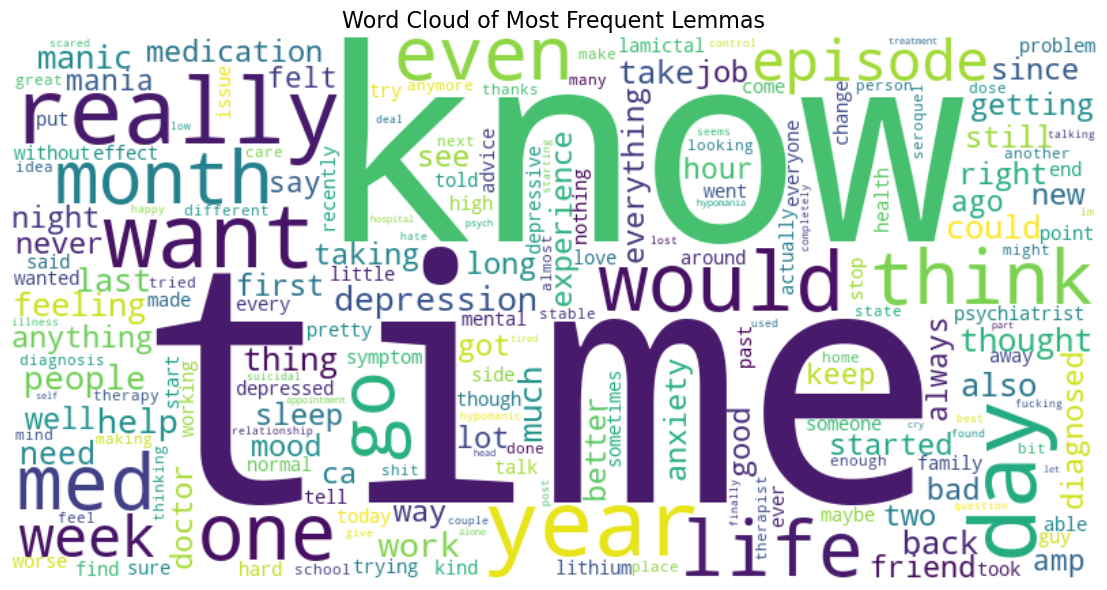

In [11]:
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_count)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Frequent Lemmas", fontsize=16)
plt.tight_layout()
plt.show()

### Top entities overall

In [12]:
all_entities = list(chain.from_iterable(bipolar_df['named_entities']))
all_entities = [word for word, _ in all_entities]
entity_counts = Counter(all_entities)

KeyError: 'named_entities'

In [13]:
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(entity_counts)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.title('Named Entity Word Cloud')
plt.axis('off')
plt.tight_layout()
plt.show()

NameError: name 'entity_counts' is not defined

### Sentiment analysis

In [ ]:
# bipolar_df = bipolar_df.drop(['compound', 'pos', 'neg', 'neu'], axis=1)

In [14]:
sia = SentimentIntensityAnalyzer()

# generates a dictionary of normalized scores (neg, neu, pos, compound)
bipolar_df['sentiment'] = bipolar_df['post'].apply(sia.polarity_scores)

# creates a dataframe from json
sentiment_df = pd.json_normalize(bipolar_df['sentiment'])

# concatenates the bipolar_df and sentiment_df columns
bipolar_df = pd.concat([bipolar_df, sentiment_df], axis=1)

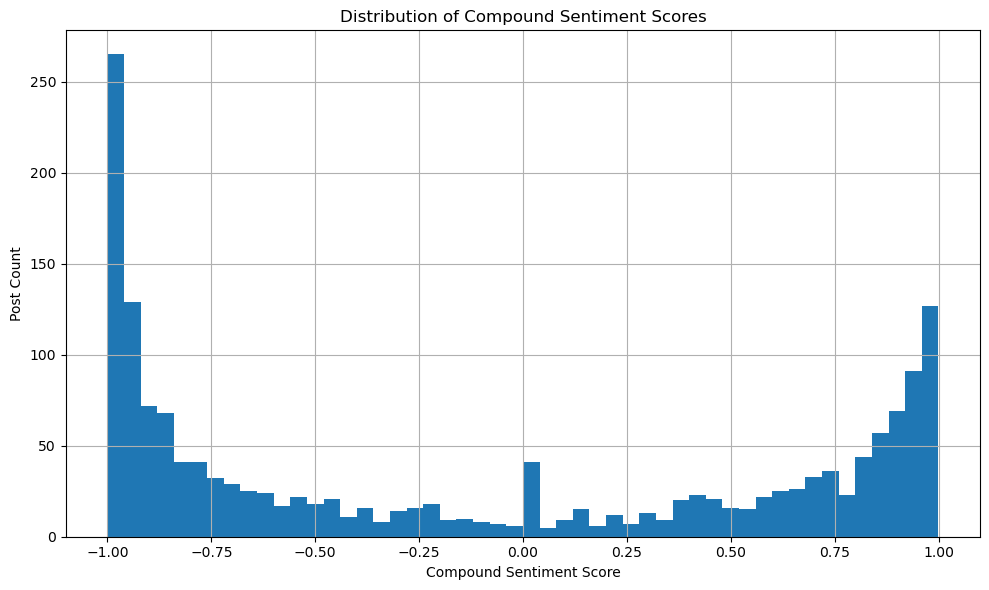

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(bipolar_df['compound'], bins=50)
plt.title('Distribution of Compound Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Post Count')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
def label_sentiment(x: float):
  if x <= -0.05:
    return 'Negative'
  if x >= 0.05:
    return 'Positive'
  return 'Neutral'

bipolar_df['sentiment_label'] = bipolar_df['compound'].apply(label_sentiment)
bipolar_df['sentiment_label'].value_counts(normalize=True)

sentiment_label
Negative    0.543735
Positive    0.427305
Neutral     0.028960
Name: proportion, dtype: float64

## Topic Modeling

### TF-IDF matrix

In [17]:
def lemmas_to_string(lemmas: list[str]):
  return ' '.join(lemma for lemma in lemmas)

bipolar_df['post_lemma_string_lowercase'] = bipolar_df['post_lemmas_lowercase'].apply(lemmas_to_string)

tfidf_vectorizer = TfidfVectorizer(
  ngram_range=(2, 3),
  min_df=5,
  max_df=0.95,
  stop_words=stop_words
)

X_tfidf = tfidf_vectorizer.fit_transform(bipolar_df['post_lemma_string_lowercase'])

### Non-Negative Matrix Factorization (NMF)

In [18]:
n_components = 10

model = NMF(
  n_components=n_components,
  init='random',
  random_state=42,
  max_iter=1000
)

W = model.fit_transform(X_tfidf) # document-topic matrix → each row shows how much each topic contributes to a post
H = model.components_ # topic-term matrix → each row is a topic, each column a term

In [19]:
feature_names = tfidf_vectorizer.get_feature_names_out() # Gets the words from the tf-idf vector

for topic_idx, topic in enumerate(H): # for loop to map the top columns in the H matrix to their corresponding words in the feature_names
  top_indices = topic.argsort()[::-1][:10] # reverse sort the top ten indices according to their topic weights
  top_words = [feature_names[i] for i in top_indices] # retrieve the feature names for the top ten indices
  print(f'Topic {topic_idx+1}: {", ".join(top_words)}') # print the n-grams corresponding to each topic

Topic 1: year ago, first time, month ago, last year, even though, year old, two year, last week, go back, started taking
Topic 2: last night, really think, dont know, started lithium, night sleep, sleep last, racing thought, know nothing, woke morning, night one
Topic 3: side effect, working really, side effect med, effect med, want take, want start, experience lithium, weight gain, know experience, really well
Topic 4: mental illness, every day, think ever, almost every, multiple time, guy ever, full time, depression anxiety, major depression, deal mental
Topic 5: depressive episode, rapid cycling, bad depressive episode, bad depressive, greatly appreciated, episode know, would greatly, major depressive, really bad, recently diagnosed
Topic 6: manic episode, episode last, mood stabilizer, high school, loved one, long term, week two, mania depression, ever experienced, full blown
Topic 7: mood swing, racing thought, manic depressive, go manic, pretty sure, gotten worse, even know, long

### LDA

In [20]:
count_vectorizer = CountVectorizer(
  ngram_range=(2, 3),
  min_df=5,
  max_df=0.95,
  stop_words=stop_words
)

X_count = count_vectorizer.fit_transform(bipolar_df['post_lemma_string_lowercase'])

In [21]:
n_components = 10

lda = LatentDirichletAllocation(
  n_components=n_components,
  random_state=42,
  max_iter=50
)

lda.fit(X_count)

,n_components,10
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,50
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


In [22]:
feature_names = count_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
  top_indices = topic.argsort()[::-1][:10]
  top_words = [feature_names[i] for i in top_indices]
  print(f'Topic {topic_idx + 1}: {", ".join(top_words)}')

Topic 1: last year, long time, mental health, depressive episode, panic attack, manic phase, two week, last week, want go, hard time
Topic 2: new year, last night, manic episode, last time, full time, stop taking, mental health, two week, got ta, time job
Topic 3: first time, rapid cycling, depressive episode, need help, next week, health insurance, side effect, gon na, manic episode, mood swing
Topic 4: side effect, taking med, recently diagnosed, weight gain, mood stabilizer, taking lithium, year ago, med change, started taking, stopped taking
Topic 5: depressive episode, last year, manic episode, go away, every day, year ago, wan na, long time, good day, every single
Topic 6: side effect, manic episode, dont know, long story, story short, long story short, mood stabilizer, every day, year ago, birth control
Topic 7: manic episode, depressive episode, month ago, first time, year old, last week, mixed episode, year ago, week ago, panic attack
Topic 8: manic episode, go back, even thou

### Top Posts and Sentiment per Topic

In [23]:
def get_top_posts(topic_idx: int, n_posts: int):
  topic_scores = W[:, topic_idx]
  top_indices = topic_scores.argsort()[::-1][:n_posts]
  return (pd.concat([bipolar_df.iloc[top_indices]['post'], sentiment_df.iloc[top_indices]['compound']], axis=1))

for i in range(n_components):
  posts = get_top_posts(i, 5)
  print(f'Topic {i}:')
  print(f"{posts.apply(lambda x: 'Sentiment: ' + str(x['compound']) + '  Content: ' + str(x['post']), axis=1)}")
  print('\n')

Topic 0:
432     Sentiment: 0.0  Content: Bipolar weightlifting...
1640    Sentiment: 0.9444  Content: Is it my disease o...
1186    Sentiment: -0.659  Content: Lost my way, cons...
152     Sentiment: -0.9701  Content: My Checkup Was A ...
376     Sentiment: 0.1027  Content: Lithium and loss o...
dtype: object


Topic 1:
959     Sentiment: -0.8944  Content: Topamax side effe...
43      Sentiment: -0.128  Content: I had two beers la...
1260    Sentiment: 0.829  Content: I feel my mood esca...
1211    Sentiment: 0.8436  Content: Can cold meds make...
37      Sentiment: -0.5707  Content: No sleep I didnt...
dtype: object


Topic 2:
793    Sentiment: -0.2144  Content: Seroquel side eff...
285    Sentiment: 0.966  Content: Started Trileptal. ...
635    Sentiment: -0.4247  Content: I'll be without l...
494    Sentiment: -0.9067  Content: Prozac and period...
949    Sentiment: 0.5197  Content: Rexulti experience...
dtype: object


Topic 3:
372     Sentiment: -0.685  Content: Essay about liv

## Topic Modeling with Embeddings

### Clustering Word Embeddings (Word2Vec)

In [24]:
w2v_model = Word2Vec(
  sentences=bipolar_df['post_lemmas_lowercase'], # expects list of tokens
  vector_size=100, # dimensionality of the word vectors
  window=5, # context window size
  min_count=5, # ignore words that appear fewer than 5 times
  workers=4, # parallelization
  seed=42
)

In [25]:
print(w2v_model.wv['manic']) # vector for the word 'bipoar'
print(w2v_model.wv.most_similar('manic')) # words most similar to 'manic'
print(w2v_model.wv.similarity('manic', 'depression')) # cosine similarity

[ 1.39412522e-01  7.98824057e-03 -3.67453426e-01  2.46721387e-01
 -4.25604552e-01  2.62437552e-01  2.20999286e-01  5.26729941e-01
 -1.09246254e-01  9.86086428e-02 -8.59049022e-01  3.31548080e-02
  1.60147429e-01  4.58252430e-01 -2.79911250e-01 -5.10405786e-02
  1.79189354e-01 -6.00667357e-01 -1.55854866e-01 -1.41548946e-01
  3.51979095e-03  6.90518141e-01  1.01301998e-01  5.91454804e-01
  1.37650594e-01 -6.46443740e-02 -3.09501261e-01  4.60564792e-01
 -5.42712331e-01 -2.97664195e-01 -1.72461152e-01  5.34489974e-02
  2.21827164e-01  3.14372450e-01  1.86966732e-01 -2.90909320e-01
  3.30528975e-01 -5.58342993e-01  2.57414103e-01  1.50346547e-01
  1.29503578e-01 -1.18360324e-02  5.86947143e-01  2.64346991e-02
  2.30158363e-02  8.76482278e-02  3.80098820e-01  3.19133103e-01
  7.16378450e-01 -3.84166002e-01 -5.76314211e-01 -1.24824011e+00
  1.96041614e-01  1.47829885e-02  9.02216956e-02 -1.80553049e-01
 -4.66410220e-01  1.83053136e-01 -2.00600371e-01  6.75814033e-01
 -1.82497099e-01 -2.67016

In [26]:
words = list(w2v_model.wv.key_to_index) # get all words in the vocabulary
word_vectors = np.array([w2v_model.wv[word] for word in words])

In [27]:
n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans.fit(word_vectors)

word_clusters = kmeans.labels_ # each word now has a cluster label

In [28]:
clusters = defaultdict(list)

for word, label in zip(words, word_clusters):
  clusters[label].append(word)

# print top words per cluster:
for cluster_id, cluster_words in clusters.items():
  print(f"Cluster {cluster_id}: {', '.join(cluster_words[:10])}\n")

Cluster 6: time, year, day, med, month, episode, week, depression, last, manic

Cluster 1: know, really, want, would, one, go, life, think, even, people

Cluster 8: amp, nbsp

Cluster 4: anymore, stable, great, therapist, low, happy, tired, hypomania, understand, live

Cluster 3: hey, anxious, swing, happen, doc, wish, sad, reading, worked, die

Cluster 5: miss, hold, afford, stabilizer, amazing, lamotrigine, fucked, summer, talked, figure

Cluster 0: hospitalized, opinion, shift, appreciate, guilty, changing, vent, single, harm, gon

Cluster 9: combo, harder, alive, missed, creative, rash, offer, hopeless, meant, send

Cluster 2: desperate, down, officially, affecting, useless, ruin, fog, stranger, clue, info

Cluster 7: venting, understands, counseling, described, fixed, suspected, meantime, terrifying, hesitant, manageable



### Clustering Document Embeddings

In [29]:
# Load a lightweight, general-purpose sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Your column is already a clean string version of the posts
post_texts = bipolar_df['post_lemma_string_lowercase'].tolist()

sentence_embeddings = model.encode(post_texts, show_progress_bar=True)

Batches: 100%|██████████| 53/53 [00:04<00:00, 10.88it/s]


In [30]:
n_clusters = 10

kmeans_doc = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans_doc.fit(sentence_embeddings)

bipolar_df['doc_topic'] = kmeans_doc.labels_

### BERTopic

In [55]:
umap_model = UMAP(
  n_components=100,
  n_neighbors=50,
  min_dist=0.3,
  metric='cosine',
  random_state=42
)

vectorizer_model = CountVectorizer(ngram_range=(2, 3), min_df=5, stop_words="english")

model = BERTopic(umap_model=umap_model, vectorizer_model=vectorizer_model, language="english", verbose=True)

topics, probs = model.fit_transform(bipolar_df['post_lemma_string_lowercase'], sentence_embeddings)

2025-08-03 17:25:29,725 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-03 17:25:38,192 - BERTopic - Dimensionality - Completed ✓
2025-08-03 17:25:38,193 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-03 17:25:38,560 - BERTopic - Cluster - Completed ✓
2025-08-03 17:25:38,561 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-03 17:25:38,727 - BERTopic - Representation - Completed ✓


In [56]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1094,-1_depressive episode_mental health_manic epis...,"[depressive episode, mental health, manic epis...",[woke recognize diagnosed month ago bp ii ocd ...
1,0,131,0_new job_suicidal ideation_day week_long time,"[new job, suicidal ideation, day week, long ti...",[finding job depressed impossible finding new ...
2,1,89,1_best friend_mental health_long time_month ago,"[best friend, mental health, long time, month ...",[trying understand better hey know type questi...
3,2,62,2_weight gain_fall asleep_hour later_couple hour,"[weight gain, fall asleep, hour later, couple ...",[seroquel withdrawal suck problem sleeping eve...
4,3,60,3_manic episode_family member_know help_though...,"[manic episode, family member, know help, thou...",[post mania cognitive issue manic episode dece...
5,4,58,4_low dose_weight gain_feeling good_hey guy,"[low dose, weight gain, feeling good, hey guy,...",[depression early onset bp diagnosed luck med ...
6,5,42,5_increased dose_new doctor_low dose_started t...,"[increased dose, new doctor, low dose, started...",[lamictal memory loss hey everyone first start...
7,6,24,6_feeling good_couple day_good mood_need help,"[feeling good, couple day, good mood, need hel...",[hypomanic mess lately majority past month fee...
8,7,21,7_day ago_couple day_hypomanic episode_started...,"[day ago, couple day, hypomanic episode, start...",[latuda dose increase taking latuda since octo...
9,8,21,8_seeing psychiatrist_new psychiatrist_mood sw...,"[seeing psychiatrist, new psychiatrist, mood s...",[experience getting med pcp instead psychiatri...


In [57]:
bipolar_df['bert_topic'] = topics

In [58]:
model.visualize_topics()